<a href="https://colab.research.google.com/github/Subeska/FYP/blob/main/My_implementation_RN50x4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qlip34zx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qlip34zx
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=23b55bf77f88e6f042c69c8f8408d09378ccab738085d01b05b57b21d9d2875c
  Stored in directory: /tmp/pip-ephem-wheel-cache-h0ccika2/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [ ]:
import numpy as np
import torch
from pkg_resources import packaging #The pkg_resources module in Python is part of the setuptools package, which provides utilities for working with Python packages.

print("Torch version:", torch.__version__)


Torch version: 1.13.1+cu116


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("RN50x4")#loads the pre-trained CLIP (Contrastive Language-Image Pre-Training) model from the OpenAI CLIP library
#model - a PyTorch model object that contains the pre-trained weights of the CLIP model.
#preprocess - a function that is used to preprocess the input images before they are fed into the CLIP model.

model.cuda().eval()
#model.cuda(): This moves the model to the GPU (Graphical Processing Unit) and returns a copy of the model that is optimized for GPU computations.
#eval(): This sets the model to evaluation mode, which disables certain operations like dropout and batch normalization that are used during training but not during inference. 
input_resolution = model.visual.input_resolution # extracts the input resolution of the visual encoder of the CLIP model.
context_length = model.context_length #extracts the context length(maximum length of the input text that can be processed by the model) of the text encoder of the CLIP model.
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
#model.parameters() method returns an iterator over all the learnable parameters of the model. 
#np.prod(p.shape) calculates the total number of elements in each parameter tensor
#int(np.sum(...)) calculates the sum of the total number of elements over all the parameter tensors.
#f"{...:,}" syntax to make it easier to read
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 402M/402M [00:05<00:00, 77.2MiB/s]


Model parameters: 178,300,601
Input resolution: 288
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=288, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(288, 288))
    <function _convert_image_to_rgb at 0x7fd5fc3a0310>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
#case-insensitive tokenizer - A case-insensitive tokenizer is a text tokenizer that treats all letters in the text as if they were lowercase, regardless of their original case.
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
import os
import skimage #It provides a collection of algorithms and tools for performing common image processing tasks, such as filtering, segmentation, feature extraction, and color conversion. 
import IPython.display #IPython.display is a module in the IPython interactive computing environment that provides a set of functions for displaying rich media, such as images, videos, audio, and HTML, in the output area of an IPython notebook or console.
import matplotlib.pyplot as plt
from PIL import Image #PIL stands for Python Imaging Library, which is a library for opening, manipulating, and saving many different image file formats. 
import numpy as np

from collections import OrderedDict #The collections module in Python provides alternatives to built-in types that are more efficient, specialized, or feature-rich. 
#One of the classes provided in this module is OrderedDict, which is a dictionary that remembers the order in which items were inserted.
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina' #In this specific example, %config InlineBackend.figure_format = 'retina' is used to configure the figure format for matplotlib plots.

# images in skimage to use and their textual descriptions
descriptions = {
    "Dog": "A woman and a child are in a kitchen.",
    "players": ": A baseball player holding a bat on a field",
    "element": " A baby elephant standing next to a bigger elephant.",
    "bed": " A bed sitting in a bedroom next to a window.",
    "mouse": " A cat laying on top of a remote control.",
    "horse": " A couple of people that are on a horse.",
    "couch": "A living room with a couch and a table.", 
    "toothbrush": "A woman holding a toothbrush in her hand."
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
folder ="/content/drive/MyDrive/CLIP folder"
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        print(filename)
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
load_images_from_folder(folder)[0]

Dog.png
players.png
element.png
bed.png
mouse.png
horse.png
couch.png
toothbrush.png


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[176, 179, 187],
        [175, 178, 186],
        [174, 177, 185],
        ...,
        [182, 181, 183],
        [181, 180, 182],
        [181, 180, 182]],

       [[176, 179, 187],
        [175, 178, 186],
        [174, 177, 185],
        ...,
        [182, 181, 183],
        [181, 180, 182],
        [180, 179, 181]],

       ...,

       [[184, 203, 199],
        [169, 191, 187],
        [162, 185, 183],
        ...,
        [ 47,  28,  16],
        [ 45,  26,  14],
        [ 41,  24,  11]],

       [[184, 203, 200],
        [170, 191, 189],
        [163, 186, 184],
        ...,
        [ 47,  29,  18],
        [ 45,  26,  15],
        [ 42,  24,  13]],

       [[185, 204, 201],
        [171, 192, 190],
        [163, 186, 184],
        ...,
        [ 48,  30,  19],
        [ 45,  27,  16],
        [ 44,  26,  15]]

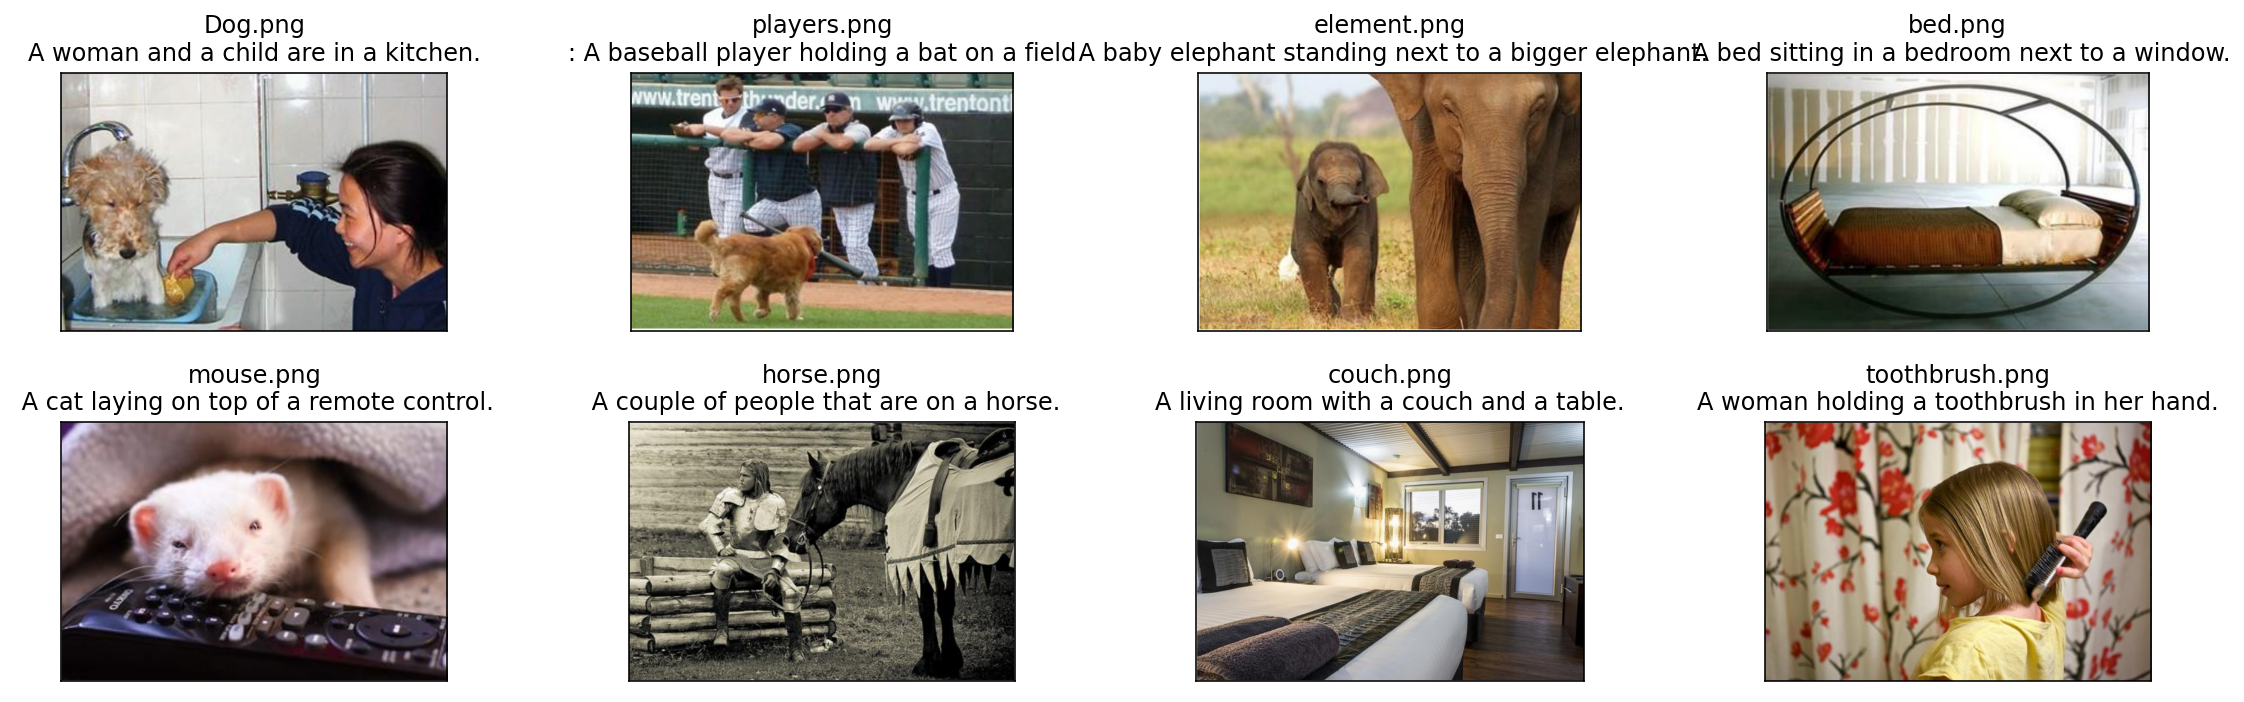

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in os.listdir(folder): 
#This is a Python code snippet that uses the os module to iterate through all the files in a directory, and select only the files with a ".png" or ".jpg" extension. 
#The code uses a list comprehension to filter the filenames, and then loops over the filtered list using a for loop.
    name = os.path.splitext(filename)[0] 
    #The os.path.splitext() function splits a path into a pair (root, ext) where ext is the extension of the file and root is the part of the path that comes before the extension.
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(folder, filename)).convert("RGB")
    #This is a Python code snippet that uses the PIL (Python Imaging Library) module to open an image file, convert it to RGB format, and assign it to the image 
  
    plt.subplot(2, 4, len(images) + 1) #subplots and specifies the location of the new subplot.
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}") #This is a Matplotlib code snippet that sets the title of a subplot with a filename and a corresponding description.
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout() #plt.tight_layout() is a Matplotlib function that automatically adjusts the subplot parameters (e.g., the padding between subplots, the size of the figure, etc.) so that the subplots fit within the figure without overlapping.




## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

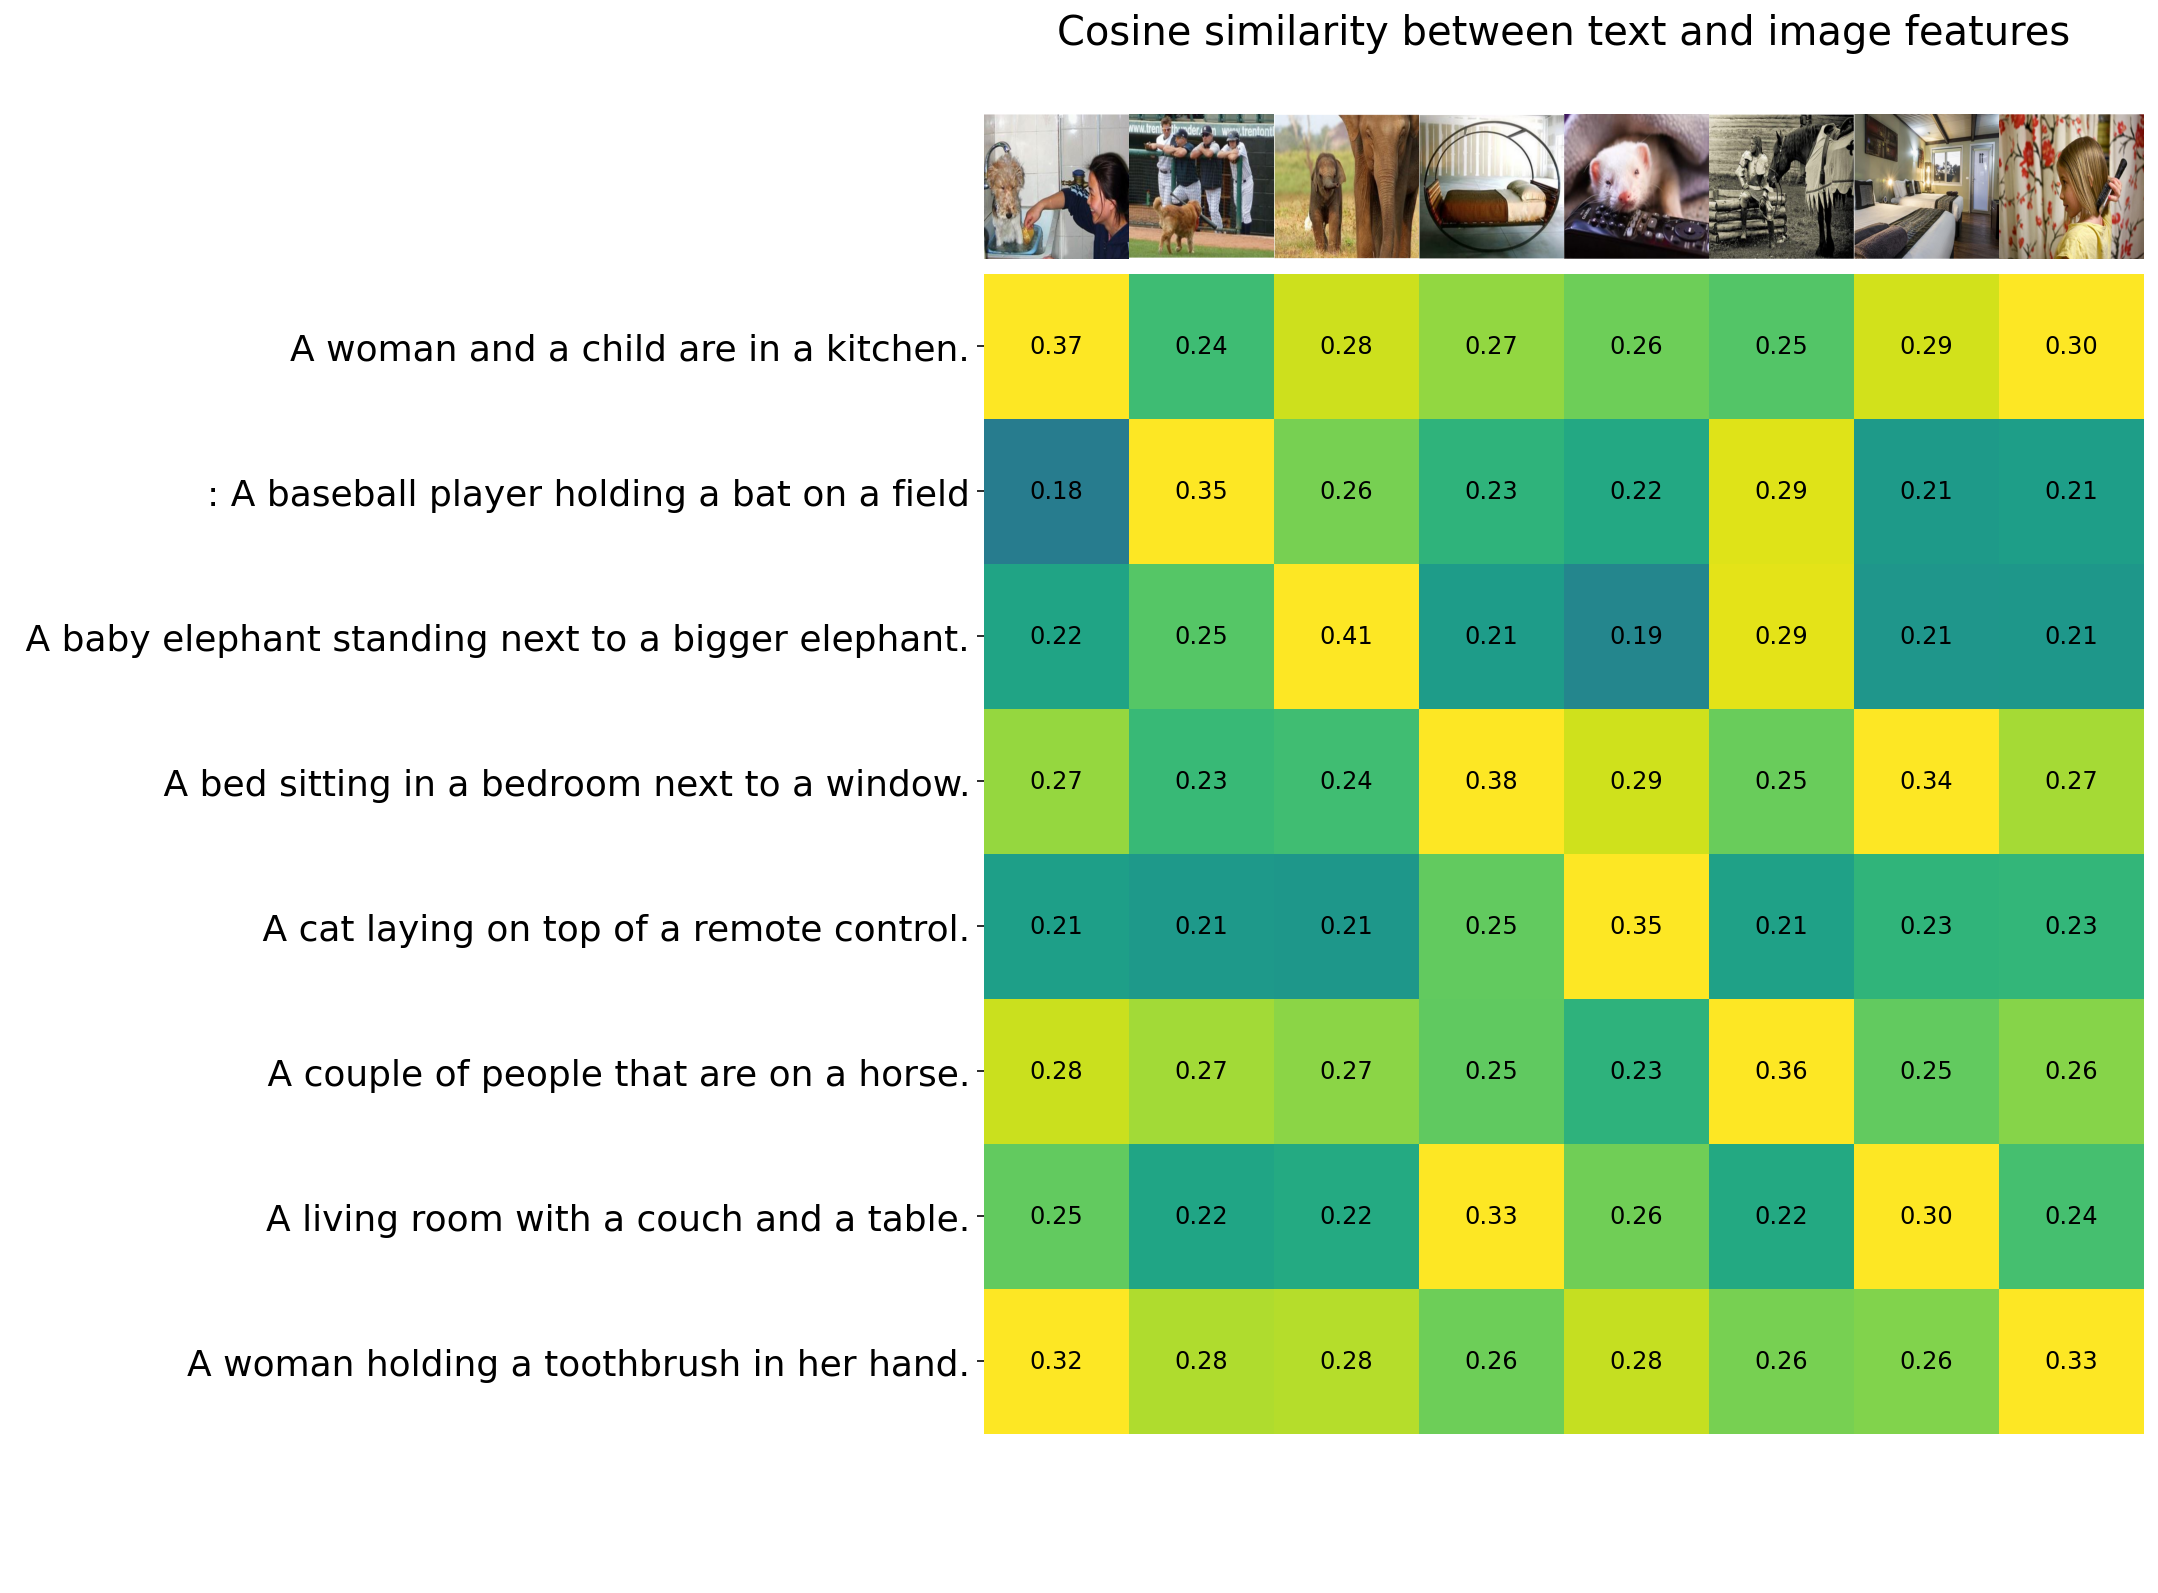

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

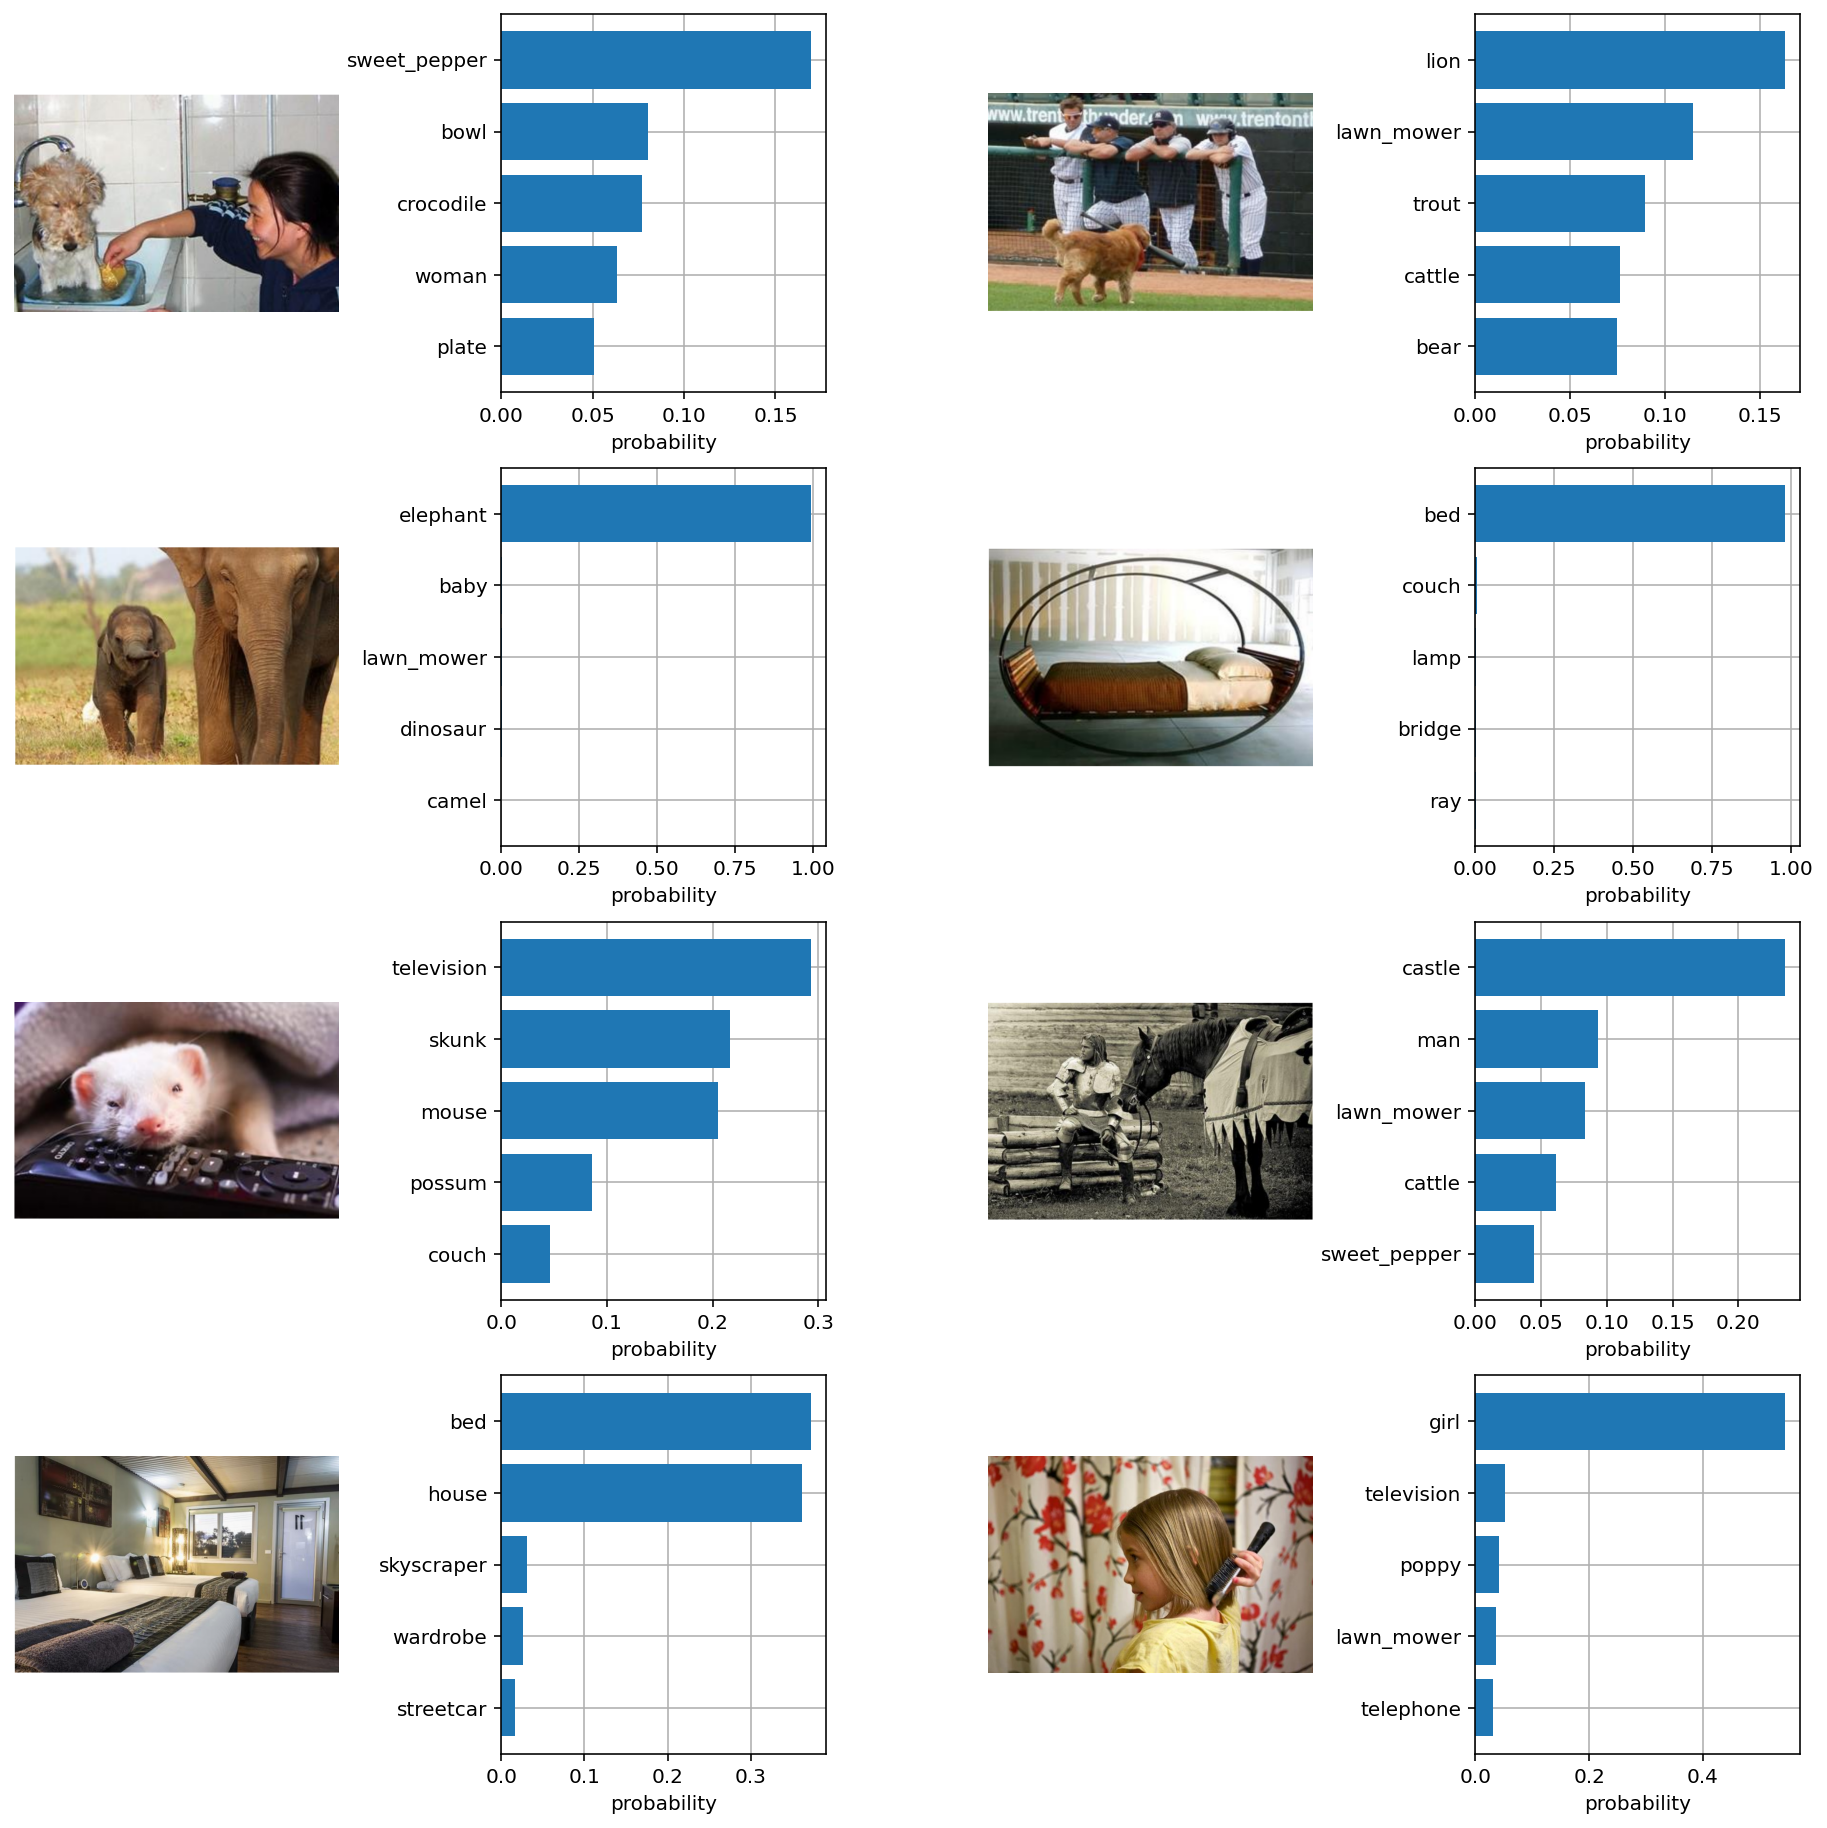

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()